# HUMAN EMOTION DETECTION

A two-class face emotion detection classifier employs transfer learning with MobileNet as the base model. This approach leverages a pre-trained MobileNet neural network to extract facial features and fine-tunes the model to distinguish between two specific emotions,happy and sad. It efficiently utilizes the pre-trained MobileNet's knowledge, making it a resource-efficient and accurate solution for emotion recognition in facial images.

## Model Setup and Evaluation

The following Python code sets up the environment and imports necessary libraries for building, training, and evaluating a deep learning model for the human emotion detection. This code includes data preprocessing, model architecture definition, and callbacks for model training.

Key libraries used:

- **NumPy:** For numerical operations.
- **Pandas:** For data manipulation and analysis.
- **Matplotlib:** For data visualization.
- **scikit-learn (sklearn):** For machine learning metrics and tools, including confusion matrix, accuracy, precision, recall, and F1 score calculations.
- **Seaborn:** For enhanced visualization of the confusion matrix.

This code serves as the foundational setup for subsequent steps in the deep learning process, including model evaluation and performance analysis.


In [1]:
# Import necessary libraries and modules

import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
import tensorflow as tf  # TensorFlow for deep learning framework
import logging  # Logging library for tracking messages and errors
import seaborn as sns  # For enhanced data visualization

# Import scikit-learn metrics for model evaluation

from sklearn.metrics import (
    roc_curve,  # ROC curve analysis
    auc,  # Area under the ROC curve
    confusion_matrix,  # Confusion matrix
    accuracy_score,  # Accuracy metric
    precision_score,  # Precision metric
    recall_score,  # Recall metric
    f1_score,  # F1 score metric
)

# Import Keras modules for deep learning

from keras.layers import Flatten, Dense  # Layers for building neural networks
from keras.models import Model  # Model class for defining neural network models
from keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img,
)  # Image data preprocessing
from keras.applications.resnet50 import ResNet50  # Import the ResNet50 model
from keras.losses import categorical_crossentropy  # Loss function for training
from keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
)  # Callbacks for model training
from keras.models import load_model  # Load pre-trained models

## Human Emotion Detection Model Setup

In this code section, we are setting up a human emotion detection model using transfer learning with a pre-trained MobileNet base. The goal of this model is to recognize and classify human emotions from input images.

**Steps:**

1. **Base Model Selection:** We initialize a MobileNet base as the foundation of our model, configuring it for processing images with a size of 224x224 pixels and excluding the top (classification) layers.

2. **Freezing Base Model Layers:** To leverage the pre-trained features, we freeze all layers in the base model, preventing them from being updated during training.

3. **Flatten and Fully Connected Layer:** We add a Flatten layer to convert the base model's output into a one-dimensional array. Next, a fully connected layer with 2 units (for emotion classification) and softmax activation is introduced.

4. **Final Model:** The resulting model is created by connecting the input to the base model and the output to the new fully connected layer.

This code initializes the structure of our human emotion detection model, which will be further trained and evaluated in subsequent steps.


In [2]:
# Working with pre trained model
base_model = ResNet50(input_shape=(224, 224, 3),
                      include_top=False, weights='imagenet')

# Freeze the layers in the base model
for layer in base_model.layers:
  layer.trainable = False

# Flatten the output of the base model
x = Flatten()(base_model.output)

# Add a fully connected layer with 4 units and softmax activation
x = Dense(units=2, activation='softmax')(x)

# Create the new model with ResNet50 base and custom top layers
model = Model(inputs=base_model.input, outputs=x)

## Compiling Emotion Detection Model

Configuring the model with 'adam' optimizer, categorical cross-entropy loss, and accuracy metric for training preparation.

In [3]:
# Compile the model with the same settings as before
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])

## Preparing the Training Data

In [4]:
import os
import random
import shutil

# Set your dataset directory
base_dir = "dataset/train"

# The target number of files per class
target_file_count = 1000

# For each class directory in the train dataset
for class_dir in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_dir)

    # Check if it's a directory
    if os.path.isdir(class_path):
        # Get all file names
        files = os.listdir(class_path)

        # Shuffle the list in place and truncate files to the target count
        random.shuffle(files)
        files_to_keep = files[:target_file_count]

        # Move the files to keep to a temporary directory
        temp_dir = os.path.join(base_dir, "temp_" + class_dir)
        os.makedirs(temp_dir, exist_ok=True)

        # Move files to keep into the temporary directory
        for f in files_to_keep:
            shutil.move(os.path.join(class_path, f), os.path.join(temp_dir, f))

        # Remove the original directory
        shutil.rmtree(class_path)

        # Rename the temporary directory back to the original directory name
        os.rename(temp_dir, class_path)

print("Truncation complete. Each class now has a maximum of 1000 files.")

Truncation complete. Each class now has a maximum of 1000 files.


## Preparing the Validation Data


In [5]:
import os
import shutil
import numpy as np

# Set the base directory where train and test folders are located
base_dir = "dataset"

# Class labels
class_labels = [
    "happy",
    "sad",
    "angry",
    "surprise",
]  # Add or modify according to your dataset

# Desired splits: 70% for training, 15% for validation, 15% for testing
train_split = 0.70
validation_split = 0.15

# Create validation directory
validation_dir = os.path.join(base_dir, "validation")
os.makedirs(validation_dir, exist_ok=True)

for label in class_labels:
    # Create subdirectories for each class label in validation directory
    os.makedirs(os.path.join(validation_dir, label), exist_ok=True)

    # Source directory (train)
    source_dir = os.path.join(base_dir, "train", label)

    # Get all file names in the source directory
    files = os.listdir(source_dir)

    # Calculate the number of files for validation
    validation_count = int(len(files) * validation_split)

    # Randomly pick files for validation
    validation_files = np.random.choice(files, validation_count, replace=False)

    # Move files to the validation directory
    for file_name in validation_files:
        shutil.move(
            os.path.join(source_dir, file_name),
            os.path.join(validation_dir, label, file_name),
        )

print("Files successfully moved to the validation folder.")

Files successfully moved to the validation folder.


## Data Preparation for Training

In this section, we specify the classes to load ("happy" and "sad"), initialize a training data generator with data augmentation options, and load images for training. The data is prepared for the emotion detection model.


In [4]:
# Specifying the classes you want to load
selected_classes = ["happy", "sad"]

# Initializing the training data generator with data augmentation options
train_datagen = ImageDataGenerator(
    zoom_range=0.2, shear_range=0.2, horizontal_flip=True, rescale=1.0 / 255
)

# Loading images from the specified classes for training
train_data = train_datagen.flow_from_directory(
    directory="dataset/train",
    classes=selected_classes,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",  # 'categorical' for multi-class classification
)

Found 1700 images belonging to 2 classes.


## Initializing the Training Data

In [5]:
train_dir = "dataset/train"

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, zoom_range=0.2, shear_range=0.2, horizontal_flip=True
)

selected_classes = ["happy", "sad"]
train_data = train_datagen.flow_from_directory(
    train_dir,
    classes=selected_classes,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
)

Found 1700 images belonging to 2 classes.


## Preparing the Test Data

In [6]:
import os
import random

# Set your dataset directory for the test set
test_dir = "dataset/test"

# The target number of files per class for the test set
target_test_file_count = 250

# For each class directory in the test dataset
for class_dir in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_dir)

    # Check if it's a directory
    if os.path.isdir(class_path):
        # Get all file names
        files = os.listdir(class_path)

        # If there are more than 250 files, we'll truncate the list
        if len(files) > target_test_file_count:
            # Randomly shuffle the list
            random.shuffle(files)

            # Select the files to remove
            files_to_remove = files[target_test_file_count:]

            # Remove the excess files
            for f in files_to_remove:
                os.remove(os.path.join(class_path, f))

print("Test dataset truncation complete.")

Test dataset truncation complete.


## Initializing Validation and Test Data

This section initializes the validation data generator and loads images from the specified classes for validation. The data is rescaled and prepared for model evaluation.


In [7]:
val_dir = "dataset/validation"
test_dir = "dataset/test"

val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

validation_data = val_datagen.flow_from_directory(
    val_dir,
    classes=selected_classes,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
)
test_data = test_datagen.flow_from_directory(
    test_dir,
    classes=selected_classes,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
)

Found 300 images belonging to 2 classes.


Found 500 images belonging to 2 classes.


## Visualizing Training Data

In this section, we visualize a subset of images from the training data generator. The code defines a function to plot images and demonstrates it with a sample batch of images.


In [10]:
# # to visualize the images in the training data denerator 
# t_img , label = train_data.next()

# # function when called will plot the images 
# def plotImages(img_arr, label):
#   """
#   input  :- images array 
#   output :- plots the images 
#   """
#   count = 0
#   for im, l in zip(img_arr,label) :
#     plt.imshow(im)
#     plt.title(im.shape)
#     plt.axis = False
#     plt.show()
    
#     count += 1
#     if count == 10:
#       break

# # function call to plot the images 
# plotImages(t_img, label)

## Early Stopping and Model Checkpoint

In this section, we configure two important callbacks for model training:

### Early Stopping
- The `EarlyStopping` callback monitors the validation accuracy (`val_accuracy`) during training.
- It halts training if the validation accuracy doesn't improve by at least 0.01 (`min_delta`) for 5 consecutive epochs (`patience`).
- This helps prevent overfitting and saves training time.

### Model Checkpoint
- The `ModelCheckpoint` callback saves the best model weights to a file (`best_model.h5`) during training.
- It monitors the validation accuracy (`val_accuracy`) and saves only when accuracy improves.
- This ensures that we have the best model saved for later use.

Both callbacks are essential for efficient and effective model training and management.


In [8]:
# Callbacks
es = EarlyStopping(
    monitor="val_accuracy", min_delta=0.01, patience=5, verbose=1, mode="auto"
)
mc = ModelCheckpoint(
    filepath="best_model.h5",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="auto",
)

# putting callbacks in a list

# callbacks = [es, mc]

In [9]:
# Starting Model Training
EmoNet = model.fit(
    train_data,  # The training data generator containing augmented images.
    steps_per_epoch=len( train_data),  # Specifies the number of training steps per epoch, set to 30 in this case.
    epochs=30,  # Defines the total number of training epochs, set to 30
    validation_data=validation_data,  # Utilizes the validation data generator for evaluating the model during training.
    validation_steps=len(
        validation_data
    ),  # Determines the number of validation steps per epoch, set to 8.
    callbacks=[
        es,
        mc,
    ],  # Includes the Early Stopping (`es`) and Model Checkpoint (`mc`) callbacks for better control and monitoring.
)

Epoch 1/30


54/54 [==============================] - ETA: 0s - loss: 1.6702 - accuracy: 0.5076
Epoch 1: val_accuracy improved from -inf to 0.51667, saving model to best_model.h5


C:\Users\Munieb AWAD\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


54/54 [==============================] - 119s 2s/step - loss: 1.6702 - accuracy: 0.5076 - val_loss: 0.7189 - val_accuracy: 0.5167
Epoch 2/30
54/54 [==============================] - ETA: 0s - loss: 0.8804 - accuracy: 0.5547
Epoch 2: val_accuracy did not improve from 0.51667
54/54 [==============================] - 108s 2s/step - loss: 0.8804 - accuracy: 0.5547 - val_loss: 0.7859 - val_accuracy: 0.5067
Epoch 3/30
54/54 [==============================] - ETA: 0s - loss: 0.8657 - accuracy: 0.5382
Epoch 3: val_accuracy did not improve from 0.51667
54/54 [==============================] - 105s 2s/step - loss: 0.8657 - accuracy: 0.5382 - val_loss: 0.9934 - val_accuracy: 0.5067
Epoch 4/30
54/54 [==============================] - ETA: 0s - loss: 0.7577 - accuracy: 0.5888
Epoch 4: val_accuracy did not improve from 0.51667
54/54 [==============================] - 105s 2s/step - loss: 0.7577 - accuracy: 0.5888 - val_loss: 1.4249 - val_accuracy: 0.5000
Epoch 5/30
54/54 [===========================

## Load and Evaluate the Model

This section of the notebook focuses on loading the best-performing model and evaluating its performance. The model, saved during the training process, is loaded from a file. After loading, we retrieve the training history to analyze metrics such as accuracy and loss.

In [10]:
# Loading the best model
model = load_model("best_model.h5")

## ROC Curve Evaluation

This section is dedicated to evaluating the model's performance using the Receiver Operating Characteristic (ROC) curve. The ROC curve is a plot of the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings, providing insights into the balance between true positive and false positive rates. The Area Under the Curve (AUC) is also calculated, giving a single measure of the model's performance across all thresholds.

In [11]:
# Evaluate the model on test data
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_data.classes

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Assuming your model is trained for 3 classes: 'happy', 'sad', 'neutral'
class_labels = ["happy", "sad"]  # Adjust as per your classes

# Binarize the output classes for ROC calculation
y_true_binary = label_binarize(
    y_true, classes=[0, 1]
)  # Adjust the classes as necessary

# Predict probabilities for each class
Y_pred_probs = model.predict(test_data)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], Y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting each ROC curve
plt.figure()
for i in range(len(class_labels)):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(
            class_labels[i], roc_auc[i]
        ),
    )

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class")
plt.legend(loc="lower right")
plt.show()

16/16 [==============================] - 25s 2s/step


IndexError: index 1 is out of bounds for axis 1 with size 1

## Model Prediction on a Single Image

In this section, we load the trained model saved as 'best_model.h5' and use it to make a prediction on a single image. The process involves loading the image, preprocessing it to match the input format expected by the model, and then using the model to predict the image's class. The predicted class is then displayed along with the image. This allows us to visually inspect the model's performance on individual examples.

1/1 [==============================] - 2s 2s/step
The image is of happy


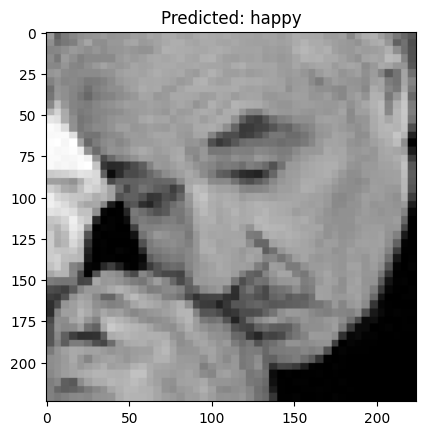

In [17]:
# Load the model
model = load_model("best_model.h5")

# Mapping output values from class indices to class labels
op = dict(zip(train_data.class_indices.values(), train_data.class_indices.keys()))

# Path to a single image for prediction
# Replace with the path to your image
path = "dataset/test/sad/PrivateTest_1495838.jpg"
img = load_img(path, target_size=(224, 224))  # Load the image and resize it

# Convert the image to a numpy array and scale the pixel values to [0, 1]
i = img_to_array(img) / 255
input_arr = np.array([i])  # Create a batch of one image

# Predict the class of the image
pred = np.argmax(model.predict(input_arr), axis=-1)

# Output the prediction
predicted_class = op[pred[0]]  # Use pred[0] because model.predict returns a batch
print(f"The image is of {predicted_class}")

# Display the image along with the predicted class
plt.imshow(input_arr[0])
plt.title(f"Predicted: {predicted_class}")
# plt.axis("off")  # Corrected line to turn off the axis
plt.show()

## Model Evaluation and Confusion Matrix

In this section, we perform model evaluation by calculating various metrics such as accuracy, precision, recall, and F1 score. Additionally, we compute and visualize the confusion matrix to assess the model's performance on emotion detection.


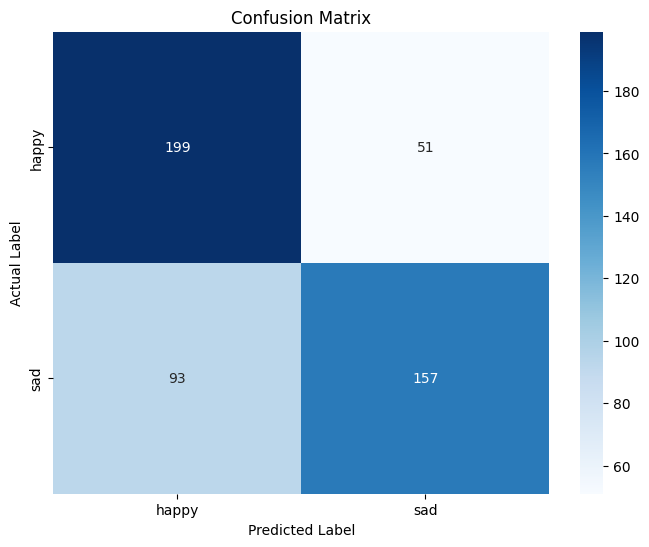

Accuracy: 0.71
Precision: 0.72
Recall: 0.71
F1 Score: 0.71

Classification Report:

              precision    recall  f1-score   support

       happy       0.68      0.80      0.73       250
         sad       0.75      0.63      0.69       250

    accuracy                           0.71       500
   macro avg       0.72      0.71      0.71       500
weighted avg       0.72      0.71      0.71       500

Cohen's Kappa Score: 0.42
Matthews Correlation Coefficient: 0.43


In [12]:
from sklearn.metrics import classification_report, cohen_kappa_score, matthews_corrcoef

# Compute the confusion matrix

cm = confusion_matrix(y_true, y_pred)


# Calculate accuracy, precision, recall, and F1 score for multi-class
accuracy = accuracy_score(y_true, y_pred)

precision = precision_score(y_true, y_pred, average="macro")

recall = recall_score(y_true, y_pred, average="macro")

f1 = f1_score(y_true, y_pred, average="macro")


# Plotting the confusion matrix

plt.figure(figsize=(8, 6))

sns.heatmap(
    cm,

    annot=True,
    fmt="d",

    cmap="Blues",

    xticklabels=["happy", "sad"],

    yticklabels=["happy", "sad"],
)

plt.title("Confusion Matrix")

plt.ylabel("Actual Label")

plt.xlabel("Predicted Label")

plt.show()


# Print the evaluation metrics

print(f"Accuracy: {accuracy:.2f}")

print(f"Precision: {precision:.2f}")

print(f"Recall: {recall:.2f}")

print(f"F1 Score: {f1:.2f}")


# Detailed classification report

print("\nClassification Report:\n")
print(
    classification_report(

        y_true, y_pred, target_names=["happy", "sad"] )

)

# Calculate Cohen's Kappa Score
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa:.2f}")

# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_true, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.2f}")